In [1]:
# the Datacenter Computing team (alexghergh)

In [2]:
from datasets import load_dataset
import torch
import torch.nn.functional as F
import torchvision
from tqdm.notebook import tqdm_notebook
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, LlamaConfig, LlamaForCausalLM

torch.set_printoptions(precision=5, sci_mode=False)

In [3]:
# make sure to run this on fep, using the ucsx queue; change to 'cpu' if you are 
# curious how slow it can get!
device = 'cuda'

## In this lab, we'll try to reproduce the paper [TinyStories: How Small Can Language Models Be and Still Speak Coherent English?](https://arxiv.org/abs/2305.07759). It's very easy to understand, so step 1 is to read this paper fully. Don't worry too much about details. What we want is to try to reproduce some of these experiments ourselves!

## 1. The dataset

As was the case for images, we need a dataset to work with. As mentioned before, HF usually holds a bunch of useful datasets, and we're lucky that the authors of the paper also uploaded their dataset on HF!

In [4]:
ds = load_dataset('roneneldan/tinystories')

In [5]:
ds['train'][0]

{'text': 'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'}

## 2. Tokenization

Now, we need some way to transform this text into numerical data, so we can apply the matrix multiplications we know (and love). This process is called **tokenization**. We'll skip how this happens under the hood, as we don't care too much about that now, but we'll use an existing well-known tokenizer (a variation of the original tokenizer used for GPT2), also used in the paper. If you're curious about building your own tokenizer, do check out [this lesson](https://huggingface.co/learn/nlp-course/chapter6/8).

In [6]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

In [7]:
# let's see how the tokenizer splits a sentence
tokenizer.tokenize('This is the craziest laboratory work in the world!')

['This',
 'Ġis',
 'Ġthe',
 'Ġcraz',
 'iest',
 'Ġlaboratory',
 'Ġwork',
 'Ġin',
 'Ġthe',
 'Ġworld',
 '!']

Notice how the tokenizer uses the weird `Ġ` to mark a whitespace, and how it split the word `craziest` into 2 tokens, `Ġcraz` and `iest`. More often than not, our tokens will not be full words, but rather sub-words. This way, we can represent all the possible imaginable words, but with just a few tokens. This tokenizer in particular has around 50k tokens, but State-of-the-Art tokenizers today (think Llama or ChatGPT) usually use 128k or even 256k tokens. Let's see the full collection of tokens (called *vocabulary*) of this tokenizer.

In [8]:
tokenizer.get_vocab()

{'w': 86,
 'gr': 2164,
 'Ġperiodic': 27458,
 'ĠRise': 15648,
 'Ġambitions': 22455,
 'Ġrankings': 16905,
 'manuel': 18713,
 'Ġalright': 23036,
 'ĠHarlem': 39735,
 'Ġrecognized': 8018,
 'ĠHolt': 28330,
 'Ġscreenplay': 39769,
 'Max': 11518,
 'ĠCock': 23769,
 'ĠCand': 15518,
 'USA': 14053,
 'akra': 38004,
 'ê': 166,
 'ĠAdvanced': 13435,
 'Spl': 26568,
 'fo': 6513,
 'ÏĢ': 46582,
 'ĠSantana': 49067,
 'Ġain': 18959,
 'Ġposs': 1184,
 'ĠContest': 27297,
 'Ġalerted': 28608,
 'Ġcrippled': 38961,
 'KY': 31159,
 'Ġintegrity': 11540,
 'Ġshrink': 22085,
 'cb': 21101,
 'irteen': 22530,
 'ĠEleven': 37339,
 'Ġmurderer': 29262,
 'Ġsubversive': 49685,
 'Ġfailing': 9894,
 'Ġexemption': 19572,
 'ĠFore': 4558,
 'water': 7050,
 'ĠMining': 29269,
 'Rem': 8413,
 'line': 1370,
 'ĠKurdistan': 29439,
 'Ġagitation': 42209,
 'Ġpersuasive': 40116,
 'ĠDISTR': 34957,
 'ĠDiana': 25752,
 'ĠMourinho': 28689,
 'ĠOnline': 7467,
 'ĠRecipe': 26694,
 'ĠSlav': 34314,
 'wei': 42990,
 'Ġdefenders': 16355,
 'Ġdraped': 38425,
 'Ġed

In [9]:
# finally, let's see how the tokenizer splits one of our stories into tokens
text_tokens = tokenizer.tokenize(ds['train'][0]['text'])
print(text_tokens)

['One', 'Ġday', ',', 'Ġa', 'Ġlittle', 'Ġgirl', 'Ġnamed', 'ĠLily', 'Ġfound', 'Ġa', 'Ġneedle', 'Ġin', 'Ġher', 'Ġroom', '.', 'ĠShe', 'Ġknew', 'Ġit', 'Ġwas', 'Ġdifficult', 'Ġto', 'Ġplay', 'Ġwith', 'Ġit', 'Ġbecause', 'Ġit', 'Ġwas', 'Ġsharp', '.', 'ĠLily', 'Ġwanted', 'Ġto', 'Ġshare', 'Ġthe', 'Ġneedle', 'Ġwith', 'Ġher', 'Ġmom', ',', 'Ġso', 'Ġshe', 'Ġcould', 'Ġsew', 'Ġa', 'Ġbutton', 'Ġon', 'Ġher', 'Ġshirt', '.', 'Ċ', 'Ċ', 'L', 'ily', 'Ġwent', 'Ġto', 'Ġher', 'Ġmom', 'Ġand', 'Ġsaid', ',', 'Ġ"', 'Mom', ',', 'ĠI', 'Ġfound', 'Ġthis', 'Ġneedle', '.', 'ĠCan', 'Ġyou', 'Ġshare', 'Ġit', 'Ġwith', 'Ġme', 'Ġand', 'Ġsew', 'Ġmy', 'Ġshirt', '?"', 'ĠHer', 'Ġmom', 'Ġsmiled', 'Ġand', 'Ġsaid', ',', 'Ġ"', 'Yes', ',', 'ĠLily', ',', 'Ġwe', 'Ġcan', 'Ġshare', 'Ġthe', 'Ġneedle', 'Ġand', 'Ġfix', 'Ġyour', 'Ġshirt', '."', 'Ċ', 'Ċ', 'Together', ',', 'Ġthey', 'Ġshared', 'Ġthe', 'Ġneedle', 'Ġand', 'Ġse', 'wed', 'Ġthe', 'Ġbutton', 'Ġon', 'ĠLily', "'s", 'Ġshirt', '.', 'ĠIt', 'Ġwas', 'Ġnot', 'Ġdifficult', 'Ġfor', 'Ġthem', 'Ġbec

In [10]:
# we also need to numericalize (i.e. assign numbers) to these tokens
# the tokenizer takes care of this for us
number_tokens = tokenizer(ds['train'][0]['text'])['input_ids']
print([*zip(text_tokens, number_tokens)])

[('One', 3198), ('Ġday', 1110), (',', 11), ('Ġa', 257), ('Ġlittle', 1310), ('Ġgirl', 2576), ('Ġnamed', 3706), ('ĠLily', 20037), ('Ġfound', 1043), ('Ġa', 257), ('Ġneedle', 17598), ('Ġin', 287), ('Ġher', 607), ('Ġroom', 2119), ('.', 13), ('ĠShe', 1375), ('Ġknew', 2993), ('Ġit', 340), ('Ġwas', 373), ('Ġdifficult', 2408), ('Ġto', 284), ('Ġplay', 711), ('Ġwith', 351), ('Ġit', 340), ('Ġbecause', 780), ('Ġit', 340), ('Ġwas', 373), ('Ġsharp', 7786), ('.', 13), ('ĠLily', 20037), ('Ġwanted', 2227), ('Ġto', 284), ('Ġshare', 2648), ('Ġthe', 262), ('Ġneedle', 17598), ('Ġwith', 351), ('Ġher', 607), ('Ġmom', 1995), (',', 11), ('Ġso', 523), ('Ġshe', 673), ('Ġcould', 714), ('Ġsew', 34249), ('Ġa', 257), ('Ġbutton', 4936), ('Ġon', 319), ('Ġher', 607), ('Ġshirt', 10147), ('.', 13), ('Ċ', 198), ('Ċ', 198), ('L', 43), ('ily', 813), ('Ġwent', 1816), ('Ġto', 284), ('Ġher', 607), ('Ġmom', 1995), ('Ġand', 290), ('Ġsaid', 531), (',', 11), ('Ġ"', 366), ('Mom', 29252), (',', 11), ('ĠI', 314), ('Ġfound', 1043), ('Ġ

Before being able to use this dataset, though, we need to do one more thing. Usually language models have something called their *"context length"*, which is a window of tokens they can "see" at prediction time. As we usually have documents of varying sizes, we need to create "chunks" of size *context_length* (also sometimes called *sequence length*). The paper uses 512 tokens to make a prediction (i.e. a context length of size 512), so that's what we'll use too!

In [31]:
context_length = 1024

In [32]:
# let's tokenize all the data in the dataset, and also chunk it into pieces of size "context_length"
# don't worry too much about what the following does; in short, it concatenates all texts, then
# simply takes chunks of equal size (if you're curious to know more about it, see
# https://huggingface.co/learn/nlp-course/chapter7/6#preparing-the-dataset)
def tokenize_and_chunk(examples):
    outputs = tokenizer(
        examples['text'],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

tokenized_ds = ds.map(
    tokenize_and_chunk, batched=True, remove_columns=ds["train"].column_names
)

Map:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Map:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [33]:
# we need to set the format of the dataset to "torch", meaning we'll use pytorch tensors
tokenized_ds.set_format('torch')

In [34]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 1238
    })
    validation: Dataset({
        features: ['input_ids'],
        num_rows: 11
    })
})

## 3. The model

Let's now pick the model to train! Although the paper used a variation of a GPT2 model, we encourage you to pick *any* model you want (this includes LLama, Gemma, GPT, Olmo etc.). Try to find one already implemented in HuggingFace, but feel free to write your own implementation if you want!

In [68]:
# let's pick a llama model as an example
# we want to have a model around 33M parameters, which is one of the results in the paper
# to get an idea of the configuration of the model, we'll check out its HF page:
# https://huggingface.co/roneneldan/TinyStories-33M/blob/main/config.json
config = LlamaConfig(vocab_size=len(tokenizer),
                     hidden_size=768,
                     intermediate_size=4*768,
                     num_hidden_layers=4,
                     num_attention_heads=16,
                     hidden_act='gelu_new',
                    )
model = LlamaForCausalLM(config)

# let's also move the model on the GPU now
model.to(device)
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(50257, 768)
    (layers): ModuleList(
      (0-3): 4 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=768, out_features=768, bias=False)
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=False)
          (o_proj): Linear(in_features=768, out_features=768, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=768, out_features=3072, bias=False)
          (up_proj): Linear(in_features=768, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=768, bias=False)
          (act_fn): NewGELUActivation()
        )
        (input_layernorm): LlamaRMSNorm((768,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((768,), eps=1e-06)
      )
    )
    (norm): L

In [69]:
# this one's around 37M parameters, without the embedings and the final layer; close enough to 33M!
sum(p.numel() for p in model.parameters()) - 2 * len(tokenizer) * 768

37755648

We'll also need an error function, as well as an optimizer. We'll pick Cross Entropy, which is the usual for language modeling, and we'll also pick [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html), which is more often used nowadays for NLP and language modeling than SGD. We'll also use similar hyperparameters (learning rate, batch size etc.) with those used in the paper, as much as possible (see [the HF page of the model](https://huggingface.co/roneneldan/TinyStories-33M)).

In [70]:
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [71]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1, betas=(0.9, 0.95))
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0004
    maximize: False
    weight_decay: 0.1
)

Finally, let's construct a dataloader from the data we have. Notice that we don't want shuffling. Remember how we chunked the data? We had to create chunks of equal sizes (of size *context_length*), and so some of the texts certainly didn't perfetly line up (so perhaps a chunk has the start of one story, and the end of the story ended up in the next chunk!). This is fine, but we have to be careful about shuffling here. We don't want to shuffle those chunks, as we need to keep the order of the texts, because they are split on separate chunks! Instead, what we should've done (and you should do) is first shuffle the documents (the stories) in the initial dataset, and **then** chunk those.

In [72]:
# create the dataloader (we'll use only batch_size 32, instead of 80, as was reported in the paper,
# because we don't have enough memory on an A100 GPU)
dl = torch.utils.data.DataLoader(tokenized_ds['train'], batch_size=16, shuffle=False)
dl

And finally, we have a *very* similar training loop with the one we used for MNIST. Nothing changes, except some small particularities about the model and data. We'll keep the epochs at 1, since this dataset is (relatively) big, but you can play around and see if more epochs help.

One more thing before we train. Since this could take a while (maybe a few dozen minutes to 1 hour on 1 A100 GPU), we'll use [tqdm](https://tqdm.github.io/), which will print a very nice progress bar for us.

In [73]:
epochs = 4
losses = []

for epoch in range(epochs):

    for batch in tqdm_notebook(dl, total=len(dl)):
        # retrieve one batch of data from the dataloader
        inputs = batch['input_ids']

        # move the inputs to GPU
        inputs = inputs.to(device)
        
        labels = inputs

        # before anything else, make sure we have no gradients yet calculated/saved,
        # for any of the model parameters
        optimizer.zero_grad()

        # calculate the output of the model (we need the "logits" of the model, which
        # is what the output of the final linear layer is called)
        output = model(inputs).logits
        
        # we are doing next-token prediction, so we shift label scores and outputs by 1
        labels = labels[:, 1:].contiguous()
        shifted_output = output[:, :-1, :].contiguous()

        # calculate the loss (error) of the model with respect to the labels
        loss = loss_fn(shifted_output.view(-1, shifted_output.size(-1)), labels.view(-1))

        # save the loss value
        losses.append(loss.item())

        # this is where the magic happens; PyTorch now calculates the gradients AUTOMATICALLY for us,
        # and the optimizer updates the parameters with these gradients
        loss.backward()
        optimizer.step()

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

## 4. Results

First of all, let's see the loss curve.

0.060746949166059494


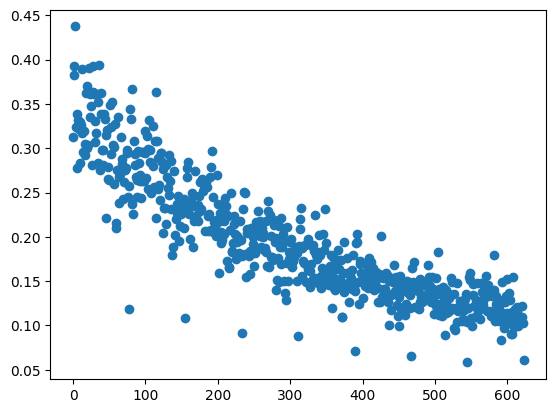

In [61]:
plt.scatter(range(len(losses)), losses)
print(losses[-1])

Good, this means we got the model to train! Now let's try doing some inference (i.e. see what the model produces when we give it some text!). We'll use some of the HF utilities as well here.

In [64]:
# try to play around with this prompt; see what the model can and can't do
text_to_complete = 'Lily said the color of the rainbow was very'

In [65]:
# inference on the model
from transformers import pipeline

pipe = pipeline('text-generation', model=model, tokenizer=tokenizer, device=device)
output = pipe(
    text_to_complete,
    max_new_tokens=256, # number of tokens to generate
    do_sample=True, # this gives us a little randomness; set to False for deterministic generation
)[0]['generated_text']

print(output)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Lily said the color of the rainbow was very little very much. She felt bad at her arm and scared. She said, "No, thank you, mom. I like the bees and I don't like the hospital. I like the cold and the thick head."

Her mom hugged her and said, "Okay, Lily. I will protect you and help you better. But you have to listen to me when the doctor will let you go."

Lily and her mom walked to the doctor and held a sticker in and held they disappeared inside. Lily was still scared small and hungry. She hoped the doctor would not fly so drop the or shouted. She said, "No, mom, I don't want to go. I want to stay here and play. Leave me, mom, I will look at home and I promise."

Lily was very angry and said, "Fine, Lily, that won't go to the doctor. The doctor will heal soon. And then, I will be done and you will be done. The doctor will be will help me at a little while. I promise."

Lily did as a cast of stickers and sat on the door. She smiled and said, " wash my teeth and stay sharp teeth. I pr

There you have it! We just trained a language model (Transformer model) from scratch! Now we just need a bigger model (hundreds of billions - 1 trillion parameters), coupled with more data (terabytes of text) and we get pretty close to the State-of-the-Art models (like ChatGPT or Gemini)!

One last thing! We should save this model, in case we want to load it later for inference. This way, we don't have to train it every time we want to run predictions. We'll also ask you for this model, as proof that you managed to train it!

In [66]:
sum(p.numel() for p in model.parameters())

114950400

As the model has roughly 115M parameters total, it takes about 460 MB on disk (since every parameter is an fp32 value).

In [67]:
model.save_pretrained('pretrained_language_model_weights_context_1024_8epochs')

## 5. Note about HuggingFace

Although tools like HuggingFace (HF) are great for the utilities they provide for training, models, datasets and the inference processes, we can't rely too much on them for speed and low-level optimizations. They are amazing tools to learn how the process of training a model works, though, so that's why we've been using them quite a bit, even with the abstractions they employ (the model, the tokenizer, the dataset and the inference process are abstracted for us, but that's ok for now). Most of the time, in production, faster, more custom solutions are used.

## 6. RNN's (optional)

Finally, below is a very simple RNN implementation, with only one input, one output, and one hidden layer. If you want to compare the results with the Transformer model above, feel free to train this model as well. We recommend [chapter 10](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) and [chapter 12](https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb) from `fast.ai`'s great book on machine learning for coders, for an intro on coding an RNN (where we also adapted the code from). Although these architectures are now quite obsolete, their ideas on recurrence are quite powerful and keep surfacing once in a while, so it's good to be able to know what an RNN does.

In [26]:
class RNN(torch.nn.Module):
    def __init__(self, vocab_sz, n_hidden):
        super().__init__()
        self.i_h = torch.nn.Embedding(vocab_sz, n_hidden)  # input embeddings (text -> vector)
        self.h_h = torch.nn.Linear(n_hidden, n_hidden)  # hidden layer (vector processing)
        self.h_o = torch.nn.Linear(n_hidden,vocab_sz)  # output layer (vector -> text)
        self.h = 0  # hidden state (a sort of "scratch pad" for the model)
        
    def forward(self, x):
        outs = []
        for i in range(seq_len):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs, dim=1)
    
    def reset(self):
        # reset the hidden state for every new epoch
        self.h = 0

## 7. Report

The default model had a loss that started stalling after ~50-100 iterations at a value of under 2 and had a final value of 1.47 after over 4000 loss iterations

Afterwards I tried a context window of 1024. The tokenization took a little bit longer, but the training finished way faster, but the performance was worse. It got to a 3.89 loss after ~80 loss iterations.

For the 1024 context model I tried to train 2 epochs, and the performance improved, with a 2.63 after ~160 iterations

I increased the number of epochs to 4 and I got a loss of 1.14 after ~320 iterations

For some reason I got an even higher final loss with 8 epochs of 0.06 after ~640 iterations. I think something must be wrong though, there are way less iterations steps for each epoch with a 1024 context window compared to one of 512, and the loss is very small compared to the initla run.

I also tried a context of 1024, 4 epochs and 0.0004 learning rate, and I got the same very samll final loss of 0.6. Again this seems a bit odd